# Initializing the Network object
- sizes: The list sizes contains the number of neurons in the respective layers
- biases & weights: The biases and weights in the Network object are all initialized randomly, using the Numpy np.random.randn function to generate Gaussian distributions with mean 0 and standard deviation 1. This random initialization gives our stochastic gradient descent algorithm a place to start from.

## SGD & update_mini_batch functions
The code works as follows. In each epoch, it starts by randomly shuffling the training data, and then partitions it into mini-batches of the appropriate size. This is an easy way of sampling randomly from the training data. Then for each mini_batch we apply a single step of gradient descent. This is done by the code self.update_mini_batch(mini_batch, eta), which updates the network weights and biases according to a single iteration of gradient descent, using just the training data in mini_batch.
Further, the update_mini_batch function usesThis invokes something called the backpropagation algorithm, which is a fast way of computing the gradient of the cost function. So update_mini_batch works simply by computing these gradients for every training example in the mini_batch, and then updating self.weights and self.biases appropriately.

## Sigmoid function
Note that when the input z is a vector or Numpy array, Numpy automatically applies the function sigmoid elementwise, that is, in vectorized form.

In [10]:
#### Libraries
# Standard library
import random

# Third-party libraries
import numpy as np

class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) 
                        for x, y in zip(sizes[:-1], sizes[1:])]
    
    def feedforward(self, a):
        """Return the output of the network if "a" is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The "training_data" is a list of tuples
        "(x, y)" representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If "test_data" is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in xrange(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in xrange(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print ("Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test))
            else:
                print ("Epoch {0} complete".format(j))
            
    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The "mini_batch" is a list of tuples "(x, y)", and "eta"
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw 
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb 
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in xrange(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

# Conclusion
All the heavy lifting is done in self.SGD and self.update_mini_batch.
The self.backprop method makes use of a few extra functions to help in computing the gradient, namely sigmoid_prime, which computes the derivative of the σ
 function, and self.cost_derivative.

# Training the model on the MNIST Dataset

The image below shows the model training in the terminal.

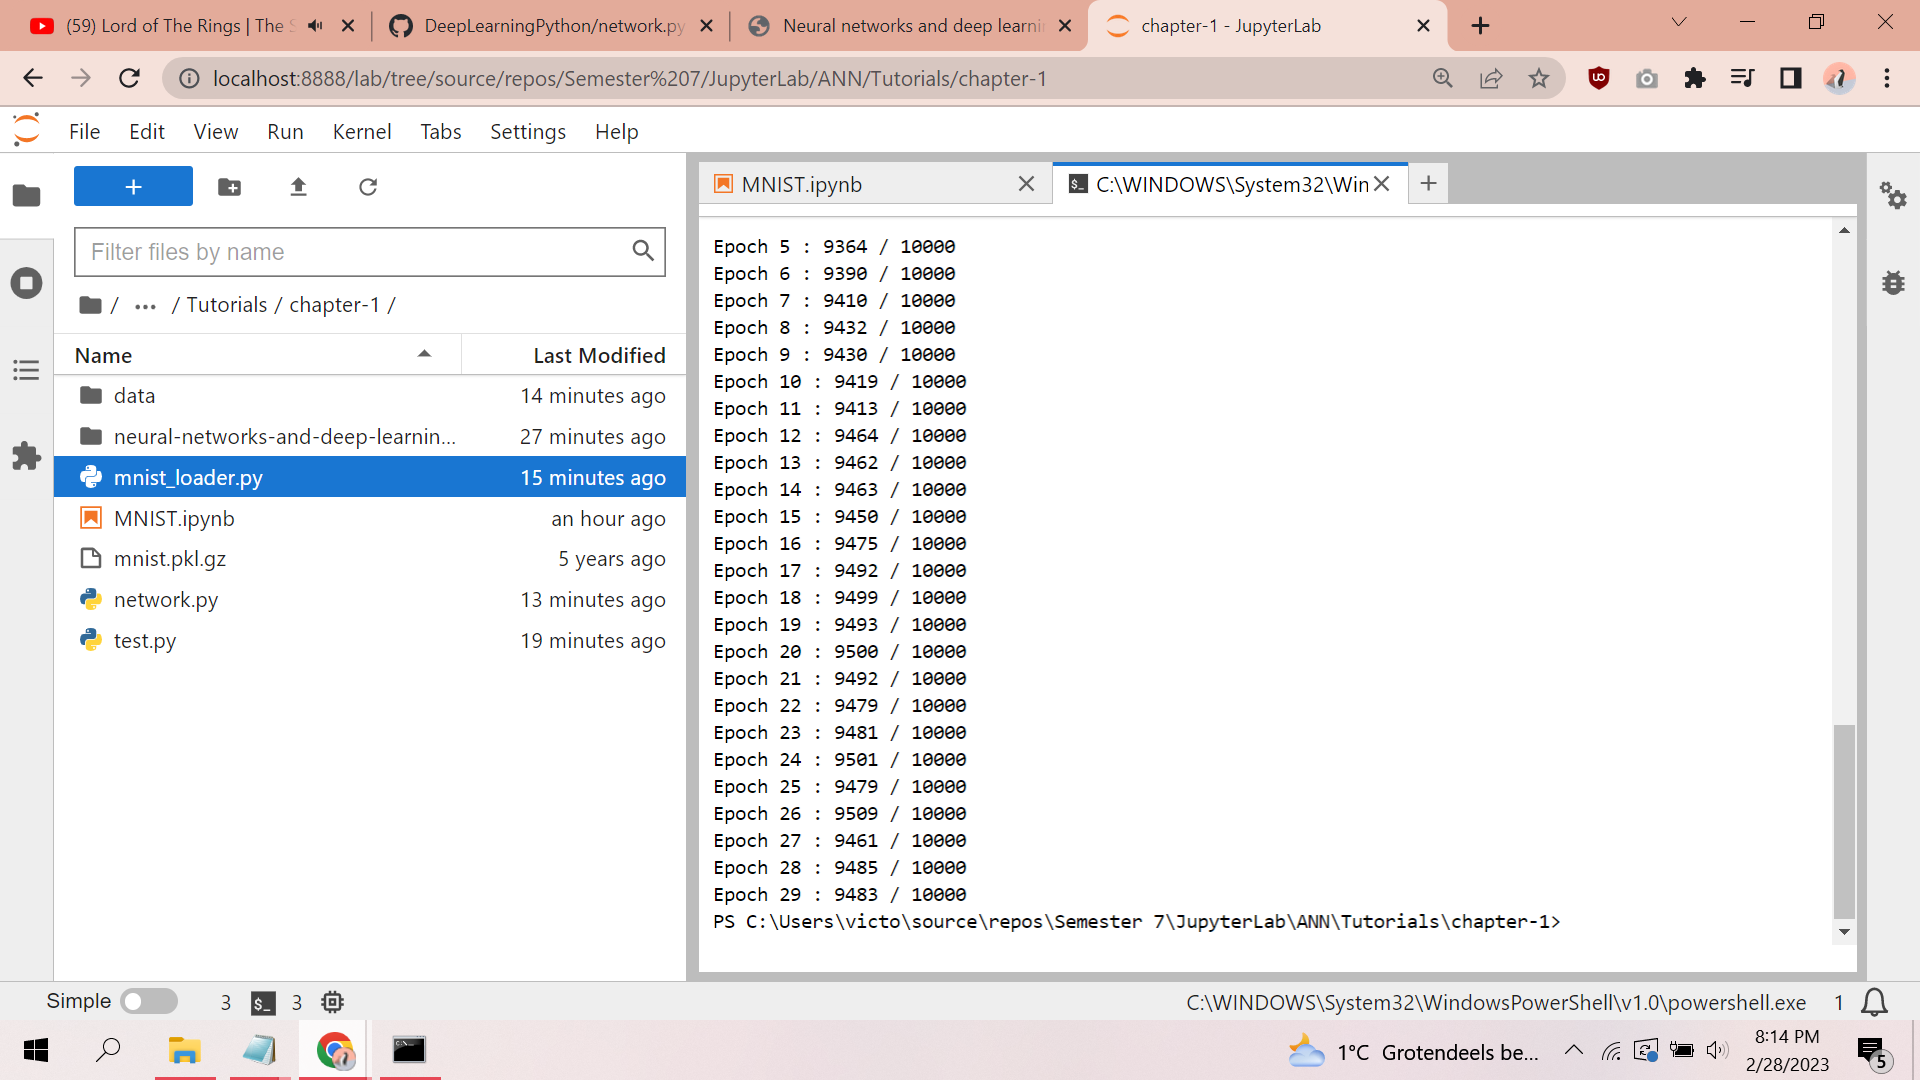

From the training we can conclude, that the trained network gives us a classification rate of about 95 percent - 94.83 percent at its peak ("Epoch 29").
The network was based on 1 hidden layer with 30 neurons.

We will now try running the model again but with 100 neurons within the hidden layer to evaluate the results.

From the results below we can see that the model this worst. we can see if this if due to the amount of neurons or the training rate. i will be using now 65 neurons

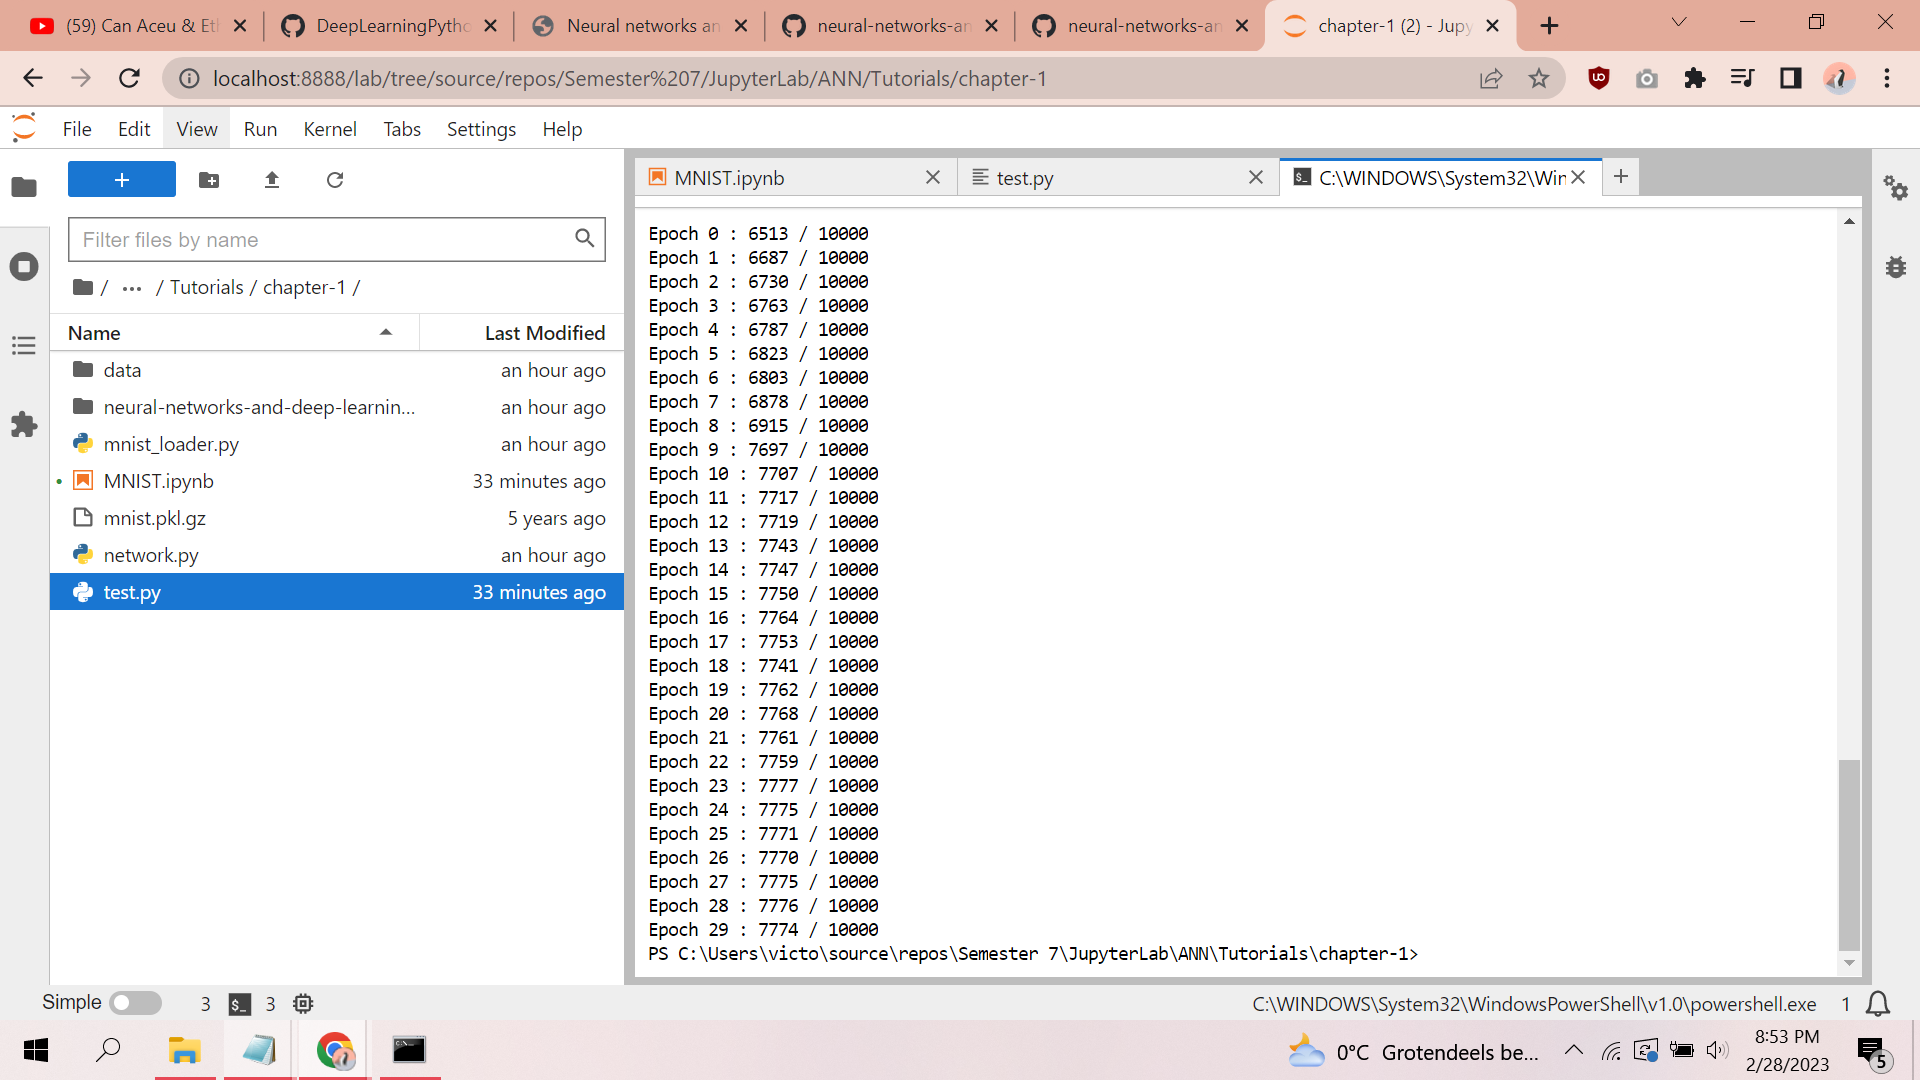

From the results below we can see that the model performs better then both the trails we did with using 30 and 100 neurons. 

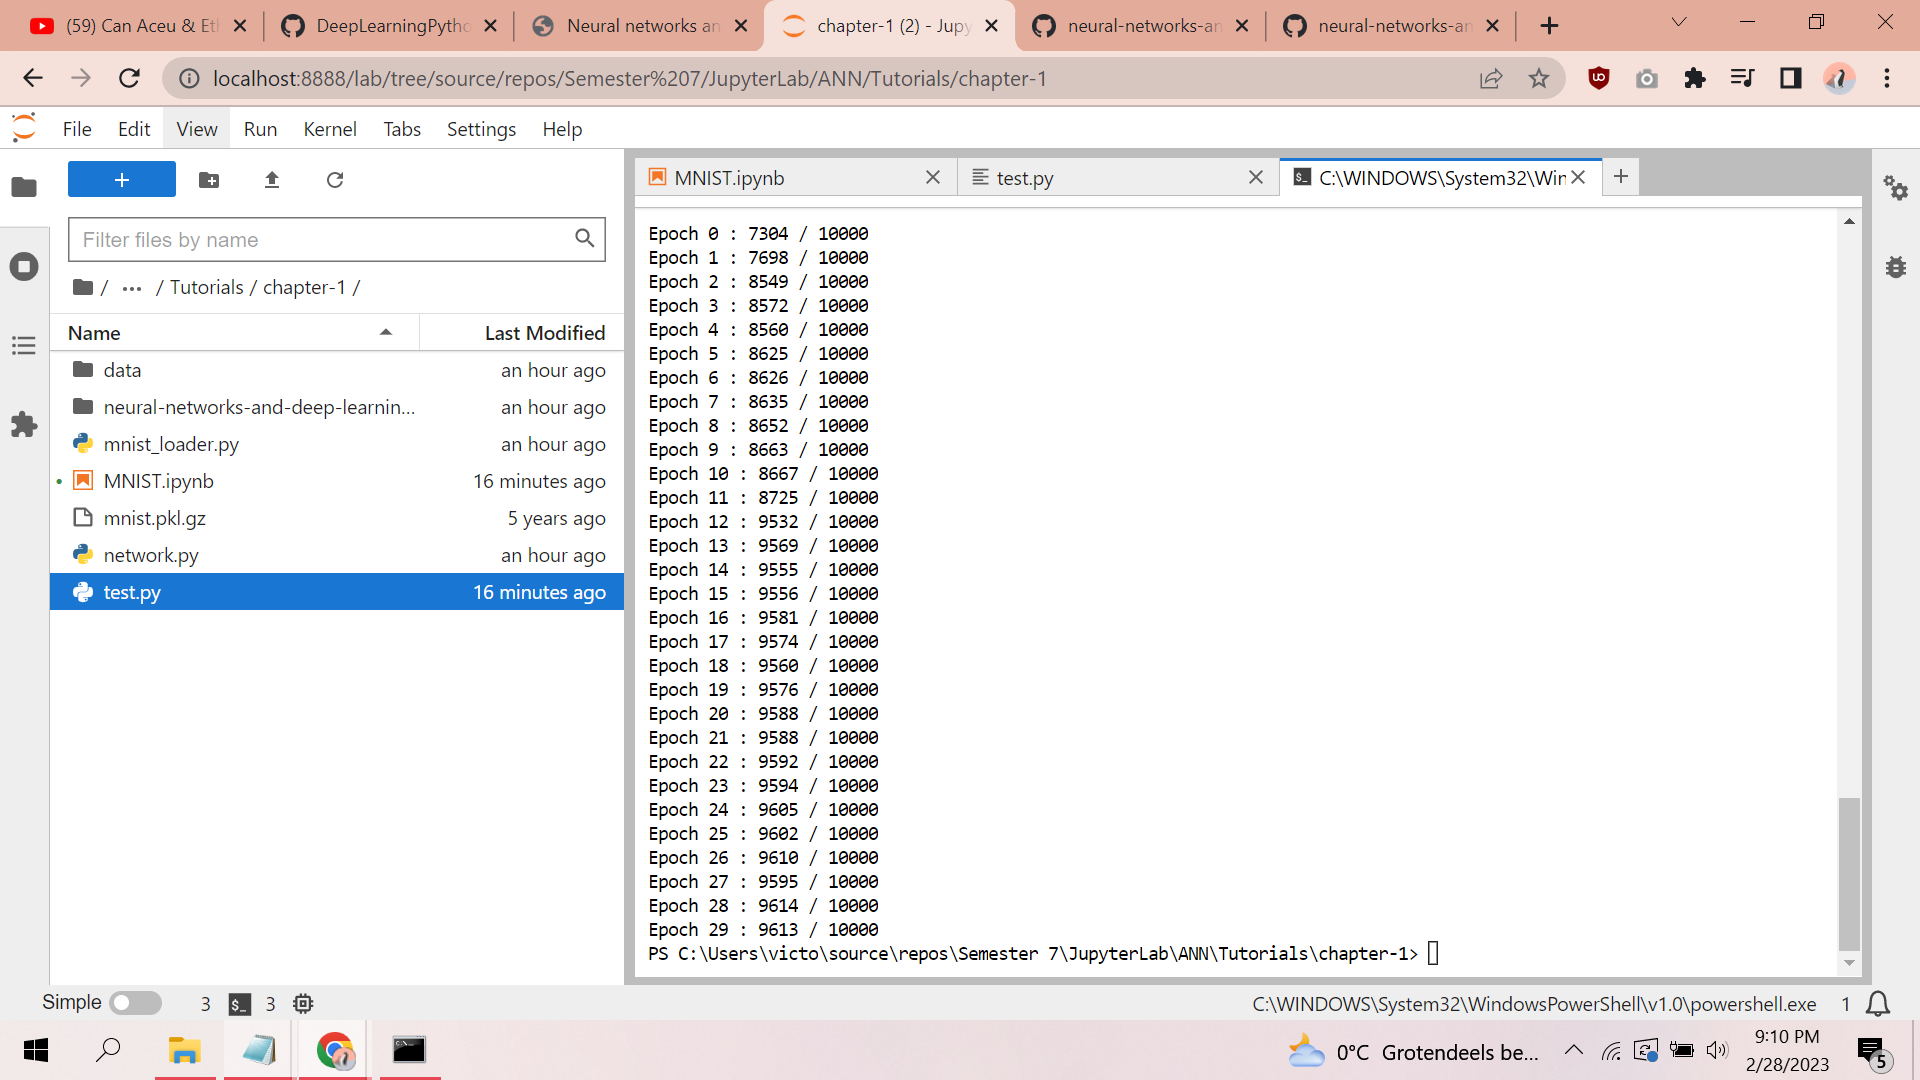

Now lets see what happens when we add 10 more neurons if the performance will be worse or better.
We can see from the results below that the training did worse when making the amount of neurons higher. Lets see what will happen if we decreased the neurons from 75 to 55. 
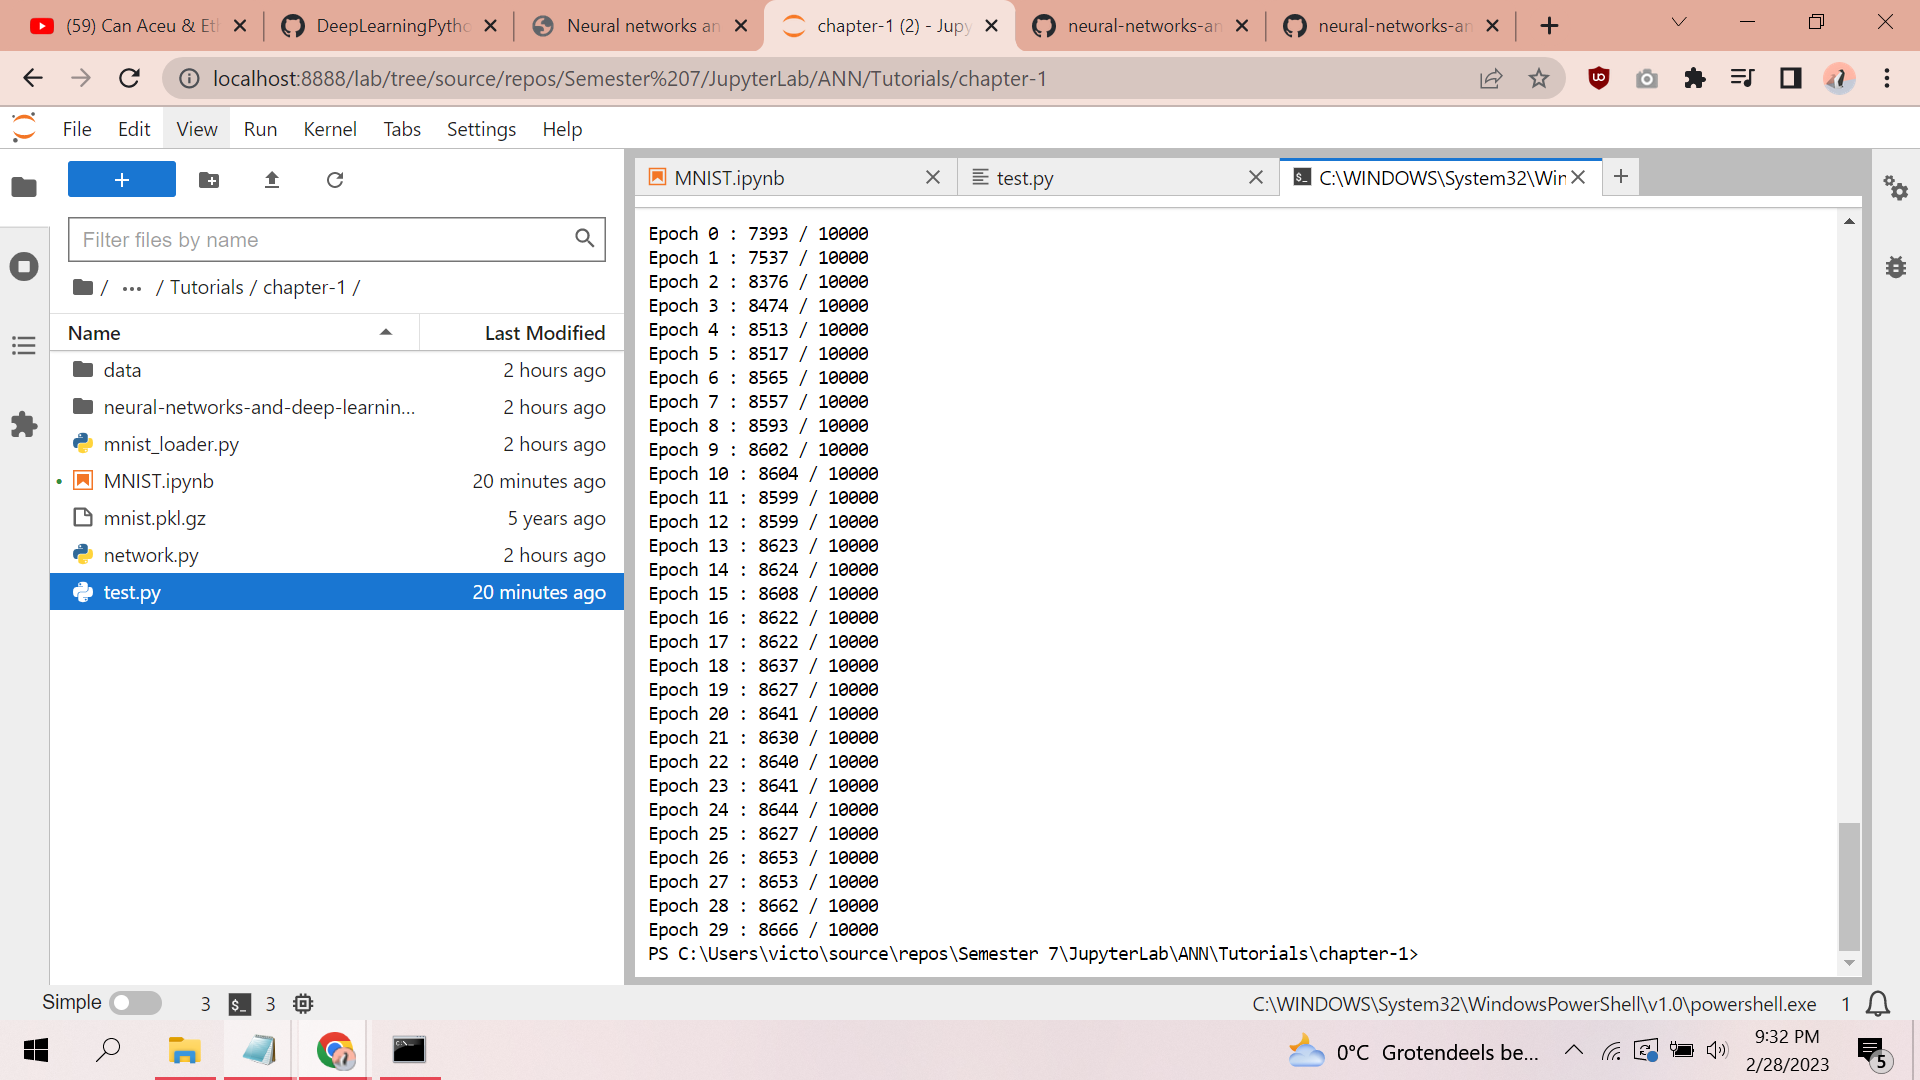

From the below results, we can see that setting the neurons for the hidden layer to 55 gives our first couple of epochs a good evaluation percentaged at starting compared to the other set neurons

And with that being said we can say that the model trains well but by playing around with the hyper parameters we can find the best fit one for the model.
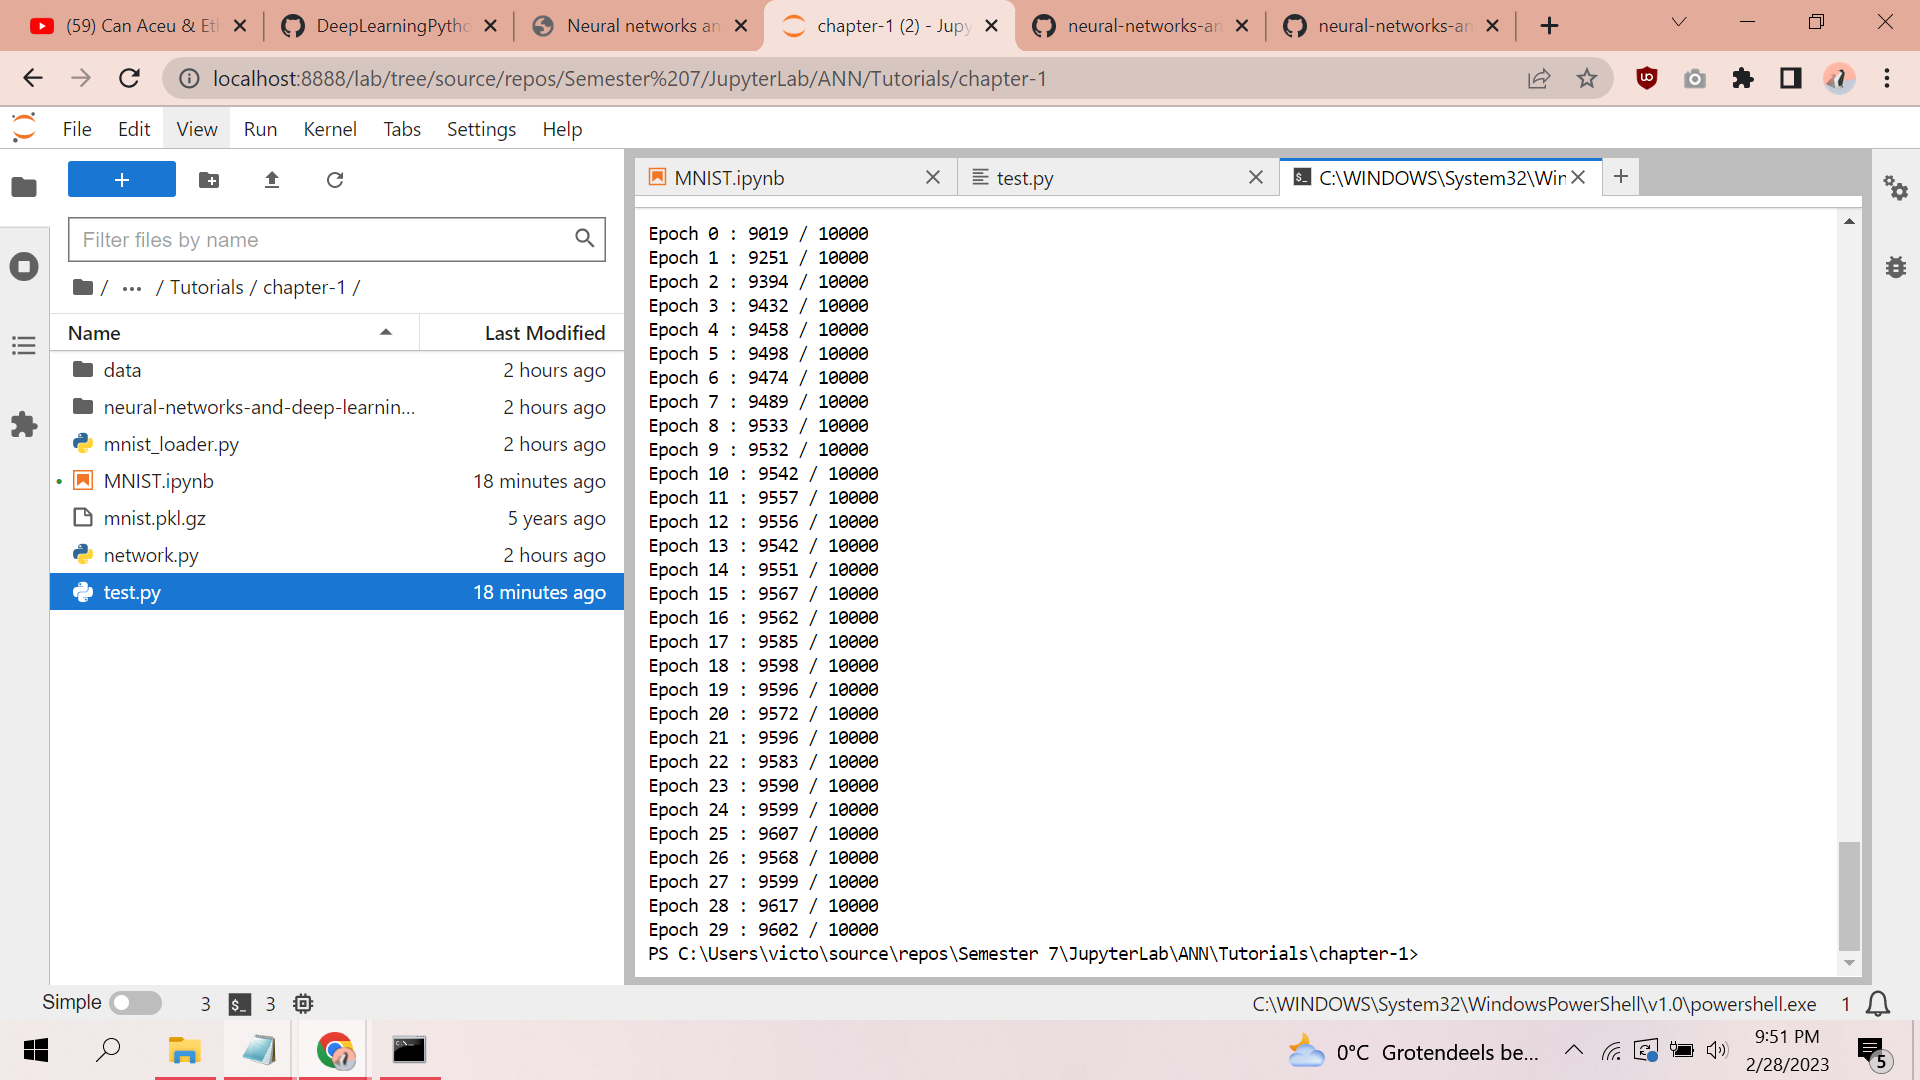